## Imports

In [1]:
import datetime
import gc
import math
import os
import pickle
import random
import sys

import keras.backend as K
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as plt
from keras import regularizers
from keras.backend import squeeze
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant, glorot_uniform, lecun_uniform
from keras.layers import LSTM, BatchNormalization, Conv3D, ConvLSTM2D, Input, Lambda
from keras.losses import binary_crossentropy, mean_absolute_error, mean_squared_error
from keras.models import Model, Sequential
from keras.optimizers import Adadelta
from keras.utils import plot_model
from matplotlib import colorbar
from matplotlib.colors import ListedColormap, Normalize, from_levels_and_colors
from matplotlib.pyplot import savefig
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
from numpy.random import seed
from scipy import stats
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed

%matplotlib inline

print(os.listdir("../input/"))

Using TensorFlow backend.


# Config

In [3]:
# choose a number of time steps
steps = 60

# model config
batch_size = 32
n_epochs = 50
verbose = 1
patience = 15
restore_weights = True

# Utils

In [4]:
# reduce memory usage by converting to proper data types
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


# plot train/val loss across the epochs
def plot_history(history, title="loss"):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Load Data

In [5]:
dtype_dict = {
    "lat": np.float16,
    "lon": np.float16,
    "U2M": np.float16,
    "T2M": np.float16,
    "V50M": np.float16,
    "T10M": np.float16,
    "SLP": np.float32,
    "V2M": np.float16,
    "V10M": np.float16,
    "U50M": np.float16,
    "U10M": np.float16,
    "QV2M": np.float16,
    "QV10M": np.float16,
    "SPEEDMAX": np.float16,
    "BSTAR": np.float16,
    "PRECTOT": np.float16,
    "GWETTOP": np.float16,
    "LAI": np.float32,
    "GWETROOT": np.float32,
    "GRN": np.float32,
    "TSURF": np.float32,
    "EVI": np.float32,
    "MIR": np.float32,
    "EVI_wasNA": np.bool,
    "MIR_wasNA": np.bool,
    "fire_count": np.float16,
    "dayOfYear": np.int16,
    "dayOfWeek": np.int8,
    "population density": np.float16,
    "SGH": np.float16,
    "lat": np.float16,
    "lon": np.float16,
    "elevation": np.float16,
    "agriculture": np.float16,
    "forest": np.float16,
    "grassland": np.float16,
    "wetland": np.float16,
    "settlement": np.float16,
    "shrubland": np.float16,
    "sparse_veg": np.float16,
    "bare_area": np.float16,
    "water": np.float16,
}

In [6]:
pd.set_option("display.max_colwidth", 1000)  # set optins to show all columns

chunks = pd.read_csv(
    "../input/basegrid_12h.csv",
    index_col=["timestamp", "lat", "lon"],
    chunksize=10e5,
    usecols=[
        "timestamp",
        "lat",
        "lon",
        "U2M",
        "T2M",
        "T10M",
        "SLP",
        "V2M",
        "V10M",
        "U10M",
        "QV2M",
        "QV10M",
        "BSTAR",
        "GWETTOP",
        "LAI",
        "GWETROOT",
        "GRN",
        "TSURF",
        "MIR",
        "population density",
        "SGH",
        "elevation",
        "agriculture",
        "forest",
        "grassland",
        "wetland",
        "settlement",
        "shrubland",
        "sparse_veg",
        "bare_area",
        "water",
        "PRECTOT",
        "dayOfYear",
        "sin_dayOfYear",
        "cos_dayOfYear",
        "fire_count",
    ],
)

df = pd.concat(chunk for chunk in chunks)

num_rows, num_cols = df.shape
num_rows, num_cols

(2233460, 33)

In [7]:
cols = [x for x in df.columns if x not in ["fire_count"]]
cols.append("fire_count")
df = df[cols]

In [8]:
df.head()

U2M    T2M   T10M         SLP    V2M  \
timestamp           lat  lon                                                 
2010-01-02 12:00:00 32.5 -123.750  0.4810  288.8  288.8  102250.840 -6.040   
                         -123.125  1.1875  288.5  288.5  102198.016 -6.367   
                         -122.500  1.7330  288.5  288.5  102133.840 -6.562   
                         -121.875  2.3790  288.0  288.0  102077.016 -6.350   
                         -121.250  2.8770  287.8  288.0  101999.680 -6.234   

                                    V10M    U10M     QV2M     QV10M     BSTAR  \
timestamp           lat  lon                                                    
2010-01-02 12:00:00 32.5 -123.750 -7.040  0.5596  0.01035  0.010240  0.000886   
                         -123.125 -7.457  1.3910  0.01027  0.010160  0.000800   
                         -122.500 -7.715  2.0370  0.01019  0.010086  0.000740   
                         -121.875 -7.516  2.8120  0.00984  0.009766  0.000181   
                         -121.250 -7.383  3.4040  0.00951  0.009400  0.000130   

                                      ...      settlement  shrubland  \
timestamp           lat  lon          ...                              
2010-01-02 12:00:00 32.5 -123.750     ...             0.0        0.0   
                         -123.125     ...             0.0        0.0   
                         -122.500     ...             0.0        0.0   
                         -121.875     ...             0.0        0.0   
                         -121.250     ...             0.0        0.0   

                                   sparse_veg  bare_area  water  PRECTOT  \
timestamp           lat  lon                                               
2010-01-02 12:00:00 32.5 -123.750         0.0        0.0    1.0      0.0   
                         -123.125         0.0        0.0    1.0      0.0   
                         -122.500         0.0        0.0    1.0      0.0   
                         -121.875         0.0        0.0    1.0      0.0   
                         -121.250         0.0        0.0    1.0      0.0   

                                   dayOfYear  sin_dayOfYear  cos_dayOfYear  \
timestamp           lat  lon                                                 
2010-01-02 12:00:00 32.5 -123.750          2       0.034422       0.999407   
                         -123.125          2       0.034422       0.999407   
                         -122.500          2       0.034422       0.999407   
                         -121.875          2       0.034422       0.999407   
                         -121.250          2       0.034422       0.999407   

                                   fire_count  
timestamp           lat  lon                   
2010-01-02 12:00:00 32.5 -123.750       -20.0  
                         -123.125       -20.0  
                         -122.500       -20.0  
                         -121.875       -20.0  
                         -121.250       -20.0  

[5 rows x 33 columns]

In [9]:
df.shape

(2233460, 33)

In [10]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 570.89 MB
Memory usage after optimization is: 153.41 MB
Decreased by 73.1%


In [11]:
gc.collect()

0

# Experimenting with fire_count as binary, filtering, and setting 0 to a negative value

In [12]:
df["fire_count"] = df["fire_count"].replace(-20, -1)

df["fire_count"].describe()

count    2233460.0
mean           NaN
std            0.0
min           -1.0
25%           -1.0
50%           -1.0
75%           -1.0
max          167.0
Name: fire_count, dtype: float64

# Preprocess Data

In [13]:
# LARGE MEMORY BOTTLENECK, CAN EAT RAM EASILY, CAN KILL KERNEL WITH LARGE DATASET
# scale the data
# separate scaler for labels to easily scale back later
scaler_features = StandardScaler()
scaler_label = StandardScaler()
df.loc[:, df.columns != "fire_count"] = scaler_features.fit_transform(
    df.loc[:, df.columns != "fire_count"]
)
df.loc[:, df.columns == "fire_count"] = scaler_label.fit_transform(
    df.loc[:, df.columns == "fire_count"]
)

In [14]:
df['fire_count'].describe()

count    2.233460e+06
mean     5.563042e-13
std      1.000000e+00
min     -7.712418e-02
25%     -7.712418e-02
50%     -7.712418e-02
75%     -7.712418e-02
max      2.130820e+02
Name: fire_count, dtype: float64

# Separate train, validation, test

In [15]:
# df_full is needed to later predict for the whole dataset
df_full = df

In [16]:
dim_time_full = len(df_full.index.get_level_values(0).unique())
dim_time_full

6569

In [17]:
df_test = df.query('timestamp >= "2018-01-01 00:00:00"')
df_valid = df.query(
    '(timestamp < "2018-01-01 00:00:00") & (timestamp >= "2017-01-01 00:00:00")'
)
df = df.query('timestamp < "2017-01-01 00:00:00"')

In [18]:
# how many timestep we have, this is going to be our first dim
dim_time_train = len(df.index.get_level_values(0).unique())
dim_time_test = len(df_test.index.get_level_values(0).unique())
dim_time_valid = len(df_valid.index.get_level_values(0).unique())
# how many lat we have
dim_lat = len(df.index.get_level_values(1).unique())
# how many lon we have
dim_lon = len(df.index.get_level_values(2).unique())
# how many features if 'fire_count' is feature, and not only label
features = len(df.columns)
# as we will drop fire as feature in loader:
features = features - 1

print("Train Dimensions: {}, {}, {}".format(dim_time_train, dim_lat, dim_lon))
print("Validation Dimensions: {}, {}, {}".format(dim_time_valid, dim_lat, dim_lon))
print("Test Dimensions: {}, {}, {}".format(dim_time_test, dim_lat, dim_lon))
print("Features: ", features)

Train Dimensions: 5111, 20, 17
Validation Dimensions: 730, 20, 17
Test Dimensions: 728, 20, 17
Features:  32


In [19]:
# convert pandas to our properly dimensionalized numpy arrays
df_np_train = (
    df.copy().values.reshape((dim_time_train, dim_lat, dim_lon, -1)).astype(np.float32)
)
df_np_valid = (
    df_valid.copy()
    .values.reshape((dim_time_valid, dim_lat, dim_lon, -1))
    .astype(np.float32)
)
df_np_test = (
    df_test.copy()
    .values.reshape((dim_time_test, dim_lat, dim_lon, -1))
    .astype(np.float32)
)
df_np_full = (
    df_full.copy()
    .values.reshape((dim_time_full, dim_lat, dim_lon, -1))
    .astype(np.float32)
)

In [20]:
# print out the shape
print(df_np_train.shape)
print(df_np_valid.shape)
print(df_np_test.shape)
print(df_np_full.shape)

(5111, 20, 17, 33)
(730, 20, 17, 33)
(728, 20, 17, 33)
(6569, 20, 17, 33)


In [21]:
# first time:
first_time = df_full.index[0][0]
first_time

'2010-01-02 12:00:00'

In [22]:
del df
del df_valid
del df_test
del df_full
gc.collect()

37

# Split Sequence Generator test

In later kernels goes to utils, here I want to check and show working.

In [23]:
# this generator gives back batches of steps long data
# fixed_batch_size=True: only full batches, remainder data isn't used
# fixed_batch_size=False: the last batch isnt dropped if not a full batch, instead the partial batch is returned
# fit_generator can use different batch sizes,
# with fixed_batch_size=False less data is wasted at the end of datasets
# with fixed_batch_size=True we can use stateful=True on convlstm (was mentioned in a forum, not sure if needed)
def steps_generator(
    sequences, steps, batch_size, fixed_batch_size=False, fire_as_feature=True
):
    X, y = list(), list()
    is_end = False
    i = 0
    while i < (len(sequences)):
        # find the end of this pattern
        end_ix = i + steps
        # check if we are beyond the dataset
        if end_ix >= len(sequences):
            end_ix = len(sequences)
            is_end = True
        # gather input and output parts of the pattern
        if fire_as_feature == True:
            seq_x, seq_y = (
                sequences[i:end_ix, :, :, :],
                sequences[i:end_ix, :, :, -1, np.newaxis],
            )
        else:
            seq_x, seq_y = (
                sequences[i:end_ix, :, :, :-1],
                sequences[i:end_ix, :, :, -1, np.newaxis],
            )
        X.append(seq_x)
        y.append(seq_y)
        i = i + 1
        # if we have our batch_size, or reached the end of data
        if ((len(X) > 0) and (len(X) % batch_size == 0)) or (is_end == True):
            # only yield if we use the not fixed batch size option, or have full batch
            if (fixed_batch_size == False) or (len(X) == batch_size):
                yield np.array(X[:]), np.array(y[:])
            X, y = list(), list()
            if is_end == True:
                i = 0
                is_end = False

In [24]:
# instantiate the generator
fixed_batch_size = False
fire_as_feature = False
generator = steps_generator(
    df_np_test,
    steps=10,
    batch_size=500,
    fixed_batch_size=fixed_batch_size,
    fire_as_feature=fire_as_feature,
)

In [25]:
# generator test, when running this cell muliple times, it will generate some full batch and a remainder batch one after another infinite
print(next(generator)[0].shape)

(500, 10, 20, 17, 32)


In [26]:
df_np_test.shape

(728, 20, 17, 33)

In [27]:
del generator

# Define Model

In [29]:
# model architecture
def get_model(
    steps,
    filter_size=60,
    kernel_size=(3, 3),
    kernel_size_3D=(3, 3, 3),
    recurrent_activation="tanh",
    out_activation=None,
    activation="linear",
    return_sequences=True,
    unit_forget_bias=True,
    recurrent_dropout=0.3,
    stateful=False,
):
    # define model
    model = Sequential()

    bias_initializer = Constant(value=0.0)  # 'zeros'
    model.add(
        ConvLSTM2D(
            filters=filter_size,
            kernel_size=kernel_size,
            padding="same",
            data_format="channels_last",
            input_shape=(
                steps,
                dim_lat,
                dim_lon,
                features,
            ),  # earlie batch_input_shape requires fixed batch size, input_shape can get it from .fit_generator
            return_sequences=True,
            unit_forget_bias=True,
            bias_initializer=bias_initializer,
            recurrent_activation=recurrent_activation,
            recurrent_dropout=0.3,
            stateful=False,
        )
    )
    model.add(BatchNormalization())

    model.add(
        ConvLSTM2D(
            filters=filter_size,
            kernel_size=kernel_size,
            padding="same",
            data_format="channels_last",
            return_sequences=True,
            unit_forget_bias=True,
            bias_initializer=bias_initializer,
            recurrent_activation=recurrent_activation,
            recurrent_dropout=0.3,
            stateful=False,
        )
    )
    model.add(BatchNormalization())

    model.add(
        ConvLSTM2D(
            filters=filter_size,
            kernel_size=kernel_size,
            padding="same",
            data_format="channels_last",
            return_sequences=True,
            unit_forget_bias=True,
            bias_initializer=bias_initializer,
            recurrent_activation=recurrent_activation,
            recurrent_dropout=0.3,
            stateful=False,
        )
    )
    model.add(BatchNormalization())

    model.add(
        ConvLSTM2D(
            filters=filter_size,
            kernel_size=kernel_size,
            padding="same",
            data_format="channels_last",
            return_sequences=True,
            unit_forget_bias=True,
            bias_initializer=bias_initializer,
            recurrent_activation=recurrent_activation,
            recurrent_dropout=0.3,
            stateful=False,
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv3D(
            filters=1,
            kernel_size=kernel_size_3D,
            padding="same",
            activation=out_activation,
            data_format="channels_last",
            kernel_regularizer=regularizers.l2(0.0001),
        )
    )
    return model

In [30]:
# for ssim choose one of the following: ssim_bce, ssim_mse, ssim_mae, ssim_mse_mae
model = get_model(steps)
loss = bce_mse
optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0, clipnorm=1.0)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 60, 20, 17, 60)    198960    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 20, 17, 60)    240       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 60, 20, 17, 60)    259440    
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 20, 17, 60)    240       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 60, 20, 17, 60)    259440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 20, 17, 60)    240       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 60, 20, 17, 60)    259440    
__________

# Setup training parameters

In [31]:
# set random seed for reproducibility
seed(42)
set_random_seed(42)
random.seed(42)

# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=patience, restore_best_weights=restore_weights)
rLR = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

In [32]:
# instantiate the generators for training, validation and testing
gen_train = steps_generator(
    df_np_train, steps=steps, batch_size=batch_size, fire_as_feature=False
)
gen_valid = steps_generator(
    df_np_valid, steps=steps, batch_size=batch_size, fire_as_feature=False
)
gen_test = steps_generator(
    df_np_test, steps=steps, batch_size=batch_size, fire_as_feature=False
)

In [33]:
# .fit_generator method needs to know how many time it have to call the generators during one epoch
if fixed_batch_size == False:
    steps_per_epoch = math.ceil((len(df_np_train) - (steps - 1)) / batch_size)
    validation_steps = math.ceil((len(df_np_valid) - (steps - 1)) / batch_size)
    test_steps = math.ceil((len(df_np_test) - (steps - 1)) / batch_size)
    full_steps = math.ceil((len(df_np_full) - (steps - 1)) / batch_size)
else:
    steps_per_epoch = (len(df_np_train) - (steps - 1)) // batch_size
    validation_steps = (len(df_np_valid) - (steps - 1)) // batch_size
    test_steps = (len(df_np_test) - (steps - 1)) // batch_size
    full_steps = (len(df_np_full) - (steps - 1)) // batch_size
print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("test_steps: ", test_steps)
print("full_steps: ", full_steps)

steps_per_epoch:  158
validation_steps:  21
test_steps:  21
full_steps:  204


In [34]:
# this starts a bit slow, but with n_step_in and not many features isnt much
# slower than the .fit method
# but works with large number of steps and features
# we have to adjust batchsize in order to not use too much ram, as with lots of features, steps, batchsize
# even one batch can be too large
H = model.fit_generator(
    generator=gen_train,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data=gen_valid,
    validation_steps=validation_steps,
    callbacks=[rLR],
)

Epoch 1/150
158/158 [==============================] - 224s 1s/step - loss: 1.3505 - val_loss: 1.8882
Epoch 2/150
158/158 [==============================] - 214s 1s/step - loss: 0.7909 - val_loss: 1.8736
Epoch 3/150
158/158 [==============================] - 214s 1s/step - loss: 0.7845 - val_loss: 1.8623
Epoch 4/150
158/158 [==============================] - 214s 1s/step - loss: 0.7826 - val_loss: 1.8571
Epoch 5/150
158/158 [==============================] - 214s 1s/step - loss: 0.7821 - val_loss: 1.8575
Epoch 6/150
158/158 [==============================] - 214s 1s/step - loss: 0.7746 - val_loss: 1.8225
Epoch 7/150
158/158 [==============================] - 214s 1s/step - loss: 0.7582 - val_loss: 1.7917
Epoch 8/150
158/158 [==============================] - 214s 1s/step - loss: 0.7375 - val_loss: 1.7597
Epoch 9/150
158/158 [==============================] - 214s 1s/step - loss: 0.7390 - val_loss: 1.7595
Epoch 10/150
158/158 [==============================] - 214s 1s/step - loss: 0.734

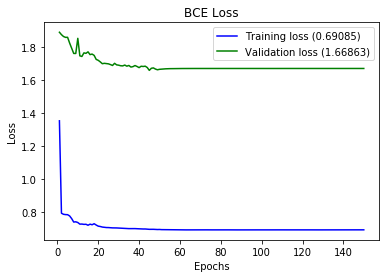

In [35]:
history = model.history
plot_history(history, title="BCE Loss")

# Make Prediction for VALIDATION data

In [36]:
fire_pred = model.predict_generator(generator=gen_valid, steps=validation_steps)
fire_pred.shape

(671, 60, 20, 17, 1)

# Inverse transform test data and prediction

In [37]:
# inverse transform prediction_data and test_data to original range
# drop unecessary dimensions for easier handling
fire_pred = scaler_label.inverse_transform(fire_pred)
fire_pred = fire_pred.squeeze()
fire_real = scaler_label.inverse_transform(df_np_valid[:, :, :, -1])
print("fire_pred shape: ", fire_pred.shape)
print("fire_real shape: ", fire_real.shape)

fire_pred shape:  (671, 60, 20, 17)
fire_real shape:  (730, 20, 17)


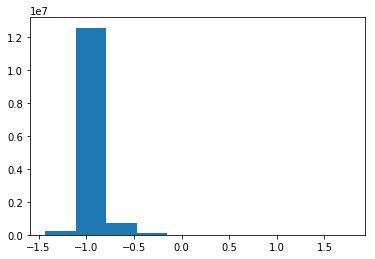

In [38]:
plt.hist(fire_pred.flatten());

In [39]:
pred_stats = stats.describe(fire_pred.flatten())
pred_stats

DescribeResult(nobs=13688400, minmax=(-1.4281664, 1.7654427), mean=-0.97084427, variance=0.01586915, skewness=5.402036190032959, kurtosis=59.69682722218926)

## Transform prediction and observation to the same dim

In [40]:
# convert the real data to the same shape as forecast for easier usage
# make a container with the shape of the forecasted data (which has steps, but observation doesnt)
extended_fire_real = np.zeros_like(fire_pred)

In [41]:
# convert the observed fire to the same dims as prediction with steps calculated from a given starting time
for start_time in range(len(extended_fire_real)):
    for i in range(steps):
        extended_fire_real[start_time, i, :, :] = fire_real[start_time + i, :, :]

In [42]:
fire_pred.shape

(671, 60, 20, 17)

In [43]:
extended_fire_real.shape

(671, 60, 20, 17)

# Calculate the scores

In [44]:
# calculate the scores with different thresholds
# th_scores [threshold, f1, precision, recall]
th_scores = []
for th in np.linspace(fire_pred.min(), fire_pred.max(), num=100, endpoint=False):
    fire_pred_exist = (fire_pred > th).astype(int)
    extended_fire_real_exist = (extended_fire_real > 0).astype(int)
    f1 = f1_score(
        fire_pred_exist[:, -1, :, :].flatten(),
        extended_fire_real_exist[:, -1, :, :].flatten(),
        pos_label=1,
    )
    recall = recall_score(
        fire_pred_exist[:, -1, :, :].flatten(),
        extended_fire_real_exist[:, -1, :, :].flatten(),
        pos_label=1,
    )
    precision = precision_score(
        fire_pred_exist[:, -1, :, :].flatten(),
        extended_fire_real_exist[:, -1, :, :].flatten(),
        pos_label=1,
    )
    th_scores.append([th, f1, precision, recall])

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


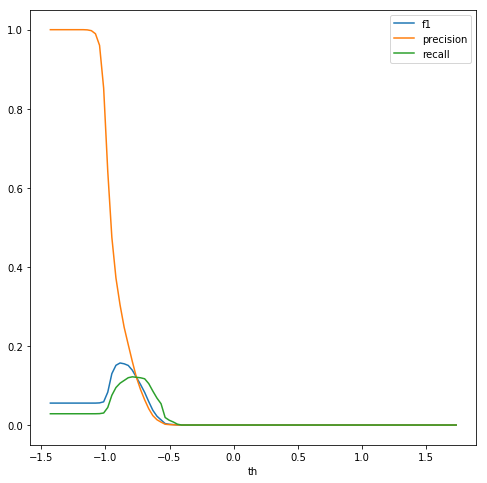

In [45]:
df_th = pd.DataFrame(th_scores, columns=["th", "f1", "precision", "recall"])
df_th.plot(x="th", y=["f1", "precision", "recall"], figsize=(8, 8))

In [46]:
best_threshold = df_th.loc[df_th["f1"].idxmax()]["th"]
print("best_threshold based on f1: ", best_threshold)
print("f1: ", df_th.loc[df_th["f1"].idxmax()]["f1"])
print("precision: ", df_th.loc[df_th["f1"].idxmax()]["precision"])
print("recall: ", df_th.loc[df_th["f1"].idxmax()]["recall"])

best_threshold based on f1:  -0.8852528393268586
f1:  0.15695921282336137
precision:  0.30379358009522345
recall:  0.10581501096667202


# Make Prediction for TEST data

In [47]:
fire_pred = model.predict_generator(generator=gen_test, steps=test_steps)
fire_pred.shape

(669, 60, 20, 17, 1)

## Inverse transform test data and prediction

In [48]:
# inverse transform prediction_data and test_data to original range
# drop unecessary dimensions for easier handling
fire_pred = scaler_label.inverse_transform(fire_pred)
fire_pred = fire_pred.squeeze()
fire_real = scaler_label.inverse_transform(df_np_test[:, :, :, -1])
print("fire_pred shape: ", fire_pred.shape)
print("fire_real shape: ", fire_real.shape)

fire_pred shape:  (669, 60, 20, 17)
fire_real shape:  (728, 20, 17)


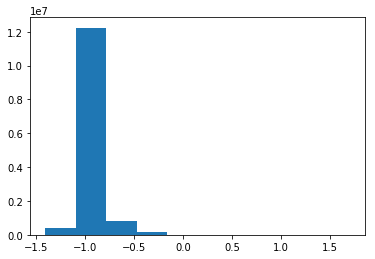

In [49]:
plt.hist(fire_pred.flatten())

## Make fire/non-fire separation

In [50]:
# make matrices where 1 is fire existence, zero is none existence
fire_pred_exist = (fire_pred > best_threshold).astype(int)
fire_real_exist = (fire_real > 0).astype(int)

In [51]:
# convert the real data to the same shape as forecast for easier usage
# make a container with the shape of the forecasted data (which has steps, but observation doesnt)
extended_fire_real_exist = np.zeros_like(fire_pred_exist)
extended_fire_real = np.zeros_like(fire_pred)

In [52]:
# convert the observed fire to the same dims as prediction with steps calculated from a given starting time
for start_time in range(len(extended_fire_real_exist)):
    for i in range(steps):
        extended_fire_real_exist[start_time, i, :, :] = fire_real_exist[
            start_time + i, :, :
        ]
        extended_fire_real[start_time, i, :, :] = fire_real[start_time + i, :, :]

In [53]:
fire_pred_exist.shape

(669, 60, 20, 17)

In [54]:
extended_fire_real_exist.shape

(669, 60, 20, 17)

In [55]:
pred_stats = stats.describe(fire_pred.flatten())
pred_stats

DescribeResult(nobs=13647600, minmax=(-1.4079112, 1.701974), mean=-0.96548426, variance=0.019092334, skewness=5.247375011444092, kurtosis=55.06997186729915)

In [56]:
pred_stats.minmax

(-1.4079112, 1.701974)

## Last step score
As here we are only interested of the last step output, we need only that score.

In [57]:
confusion_matrix(
    fire_pred_exist[:, -1, :, :].flatten(),
    extended_fire_real_exist[:, -1, :, :].flatten(),
)

array([[201664,   3375],
       [ 19247,   3174]])

In [58]:
precision_recall_fscore_support(
    fire_pred_exist[:, -1, :, :].flatten(),
    extended_fire_real_exist[:, -1, :, :].flatten(),
)

(array([0.91287442, 0.48465415]),
 array([0.98353972, 0.14156371]),
 array([0.94689048, 0.21912323]),
 array([205039,  22421]))

## Plot some examples

In [59]:
np.quantile(fire_pred[(fire_pred > best_threshold)], 0.8)

-0.5784677267074585

In [60]:
vmin = best_threshold
vmax = np.quantile(
    fire_pred[(fire_pred > best_threshold)], 0.8
)  # the 0.8 quantile of the fiery cells
vmin_broad = (pred_stats.minmax[0] + best_threshold) * 0.5


def plot_fires_by_step(start_steps=[0, 50, 100], figsize=(10, 8), vmin=vmin, vmax=vmax):
    """
    Plots the last step of forecast, as now we are interested in 
    the fire potential after a period of weather
    """
    f, axarr = plt.subplots(4, len(start_steps), figsize=figsize)
    for i, st in enumerate(start_steps):
        axarr[0, i].imshow(
            fire_pred[st, -1, :, :],
            origin="lower",
            vmin=vmin - 0.05,
            vmax=vmax,
            cmap="jet",
        )
        axarr[0, i].set_title("Pr-br {}".format(st))
        axarr[1, i].imshow(
            fire_pred[st, -1, :, :], origin="lower", vmin=vmin, vmax=vmax, cmap="jet"
        )
        axarr[1, i].set_title("Pr {}".format(st))
        axarr[2, i].imshow(
            fire_pred_exist[st, -1, :, :],
            origin="lower",
            vmin=0,
            vmax=1,
            cmap="nipy_spectral",
        )
        axarr[2, i].set_title("Pr exst {}".format(st))
        axarr[3, i].imshow(
            extended_fire_real[st, -1, :, :],
            origin="lower",
            vmin=0,
            vmax=1,
            cmap="nipy_spectral",
        )
        axarr[3, i].set_title("Act {}".format(st))

In [61]:
max_fires = np.argmax(fire_pred.sum(axis=3).sum(axis=2)[:, -1], axis=0)
min_fires = np.argmin(fire_pred.sum(axis=3).sum(axis=2)[:, -1], axis=0)

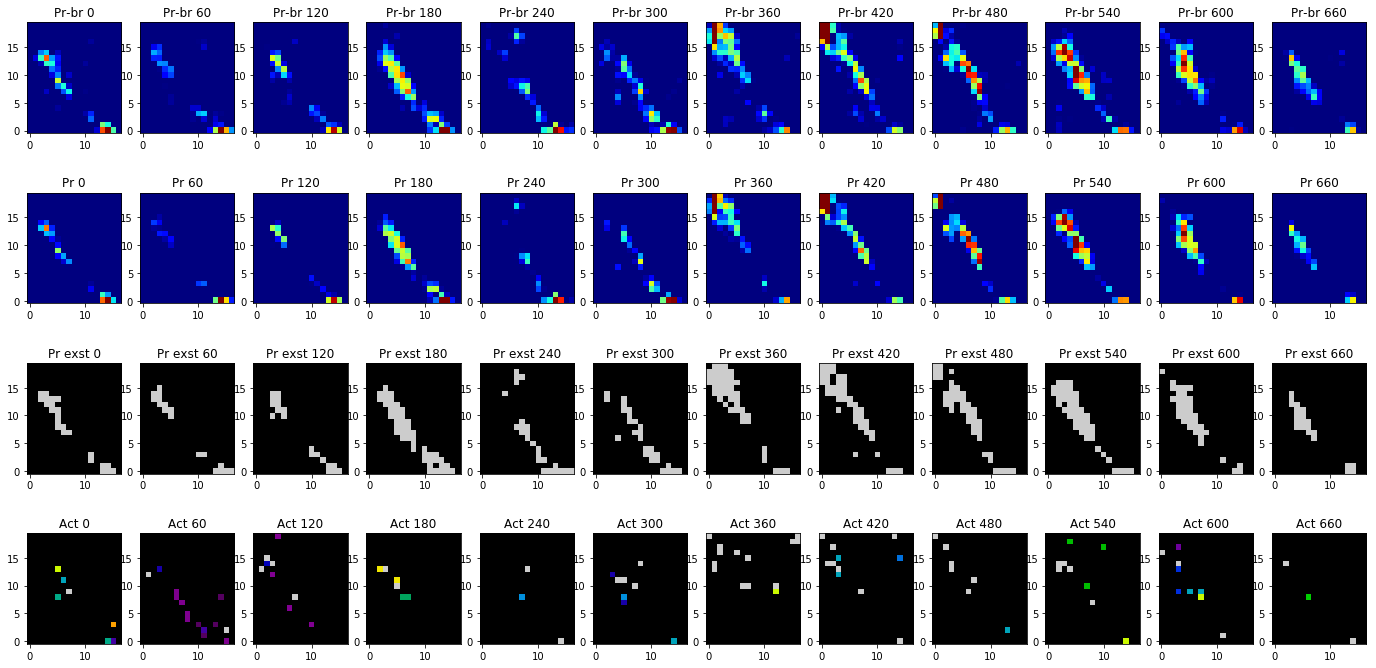

In [62]:
# lets see the 30th . . .360th day / the [0]th data is the forecast from 0th day,
# but we use the last step, so that must be added to this number to get the date
plot_fires_by_step(
    start_steps=[0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660],
    figsize=(24, 12),
)

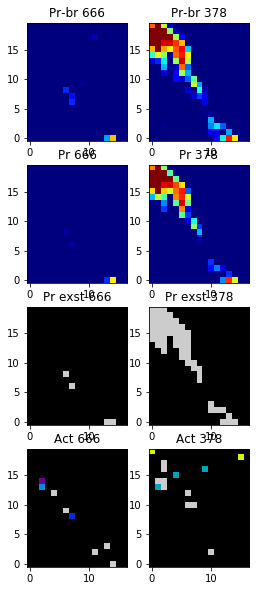

In [63]:
# less and most fiery days according to the model
plot_fires_by_step(start_steps=[min_fires, max_fires], figsize=(4, 10))

# Make full dataset prediction

In [64]:
gen_full = steps_generator(
    df_np_full, steps=steps, batch_size=batch_size, fire_as_feature=False
)

In [65]:
fire_pred_full = model.predict_generator(generator=gen_full, steps=full_steps)
fire_pred_full.shape

(6510, 60, 20, 17, 1)

In [66]:
fire_pred_full = fire_pred_full[:, -1, :, :, :].squeeze()

In [67]:
fire_pred_full.shape

(6510, 20, 17)

In [68]:
prediction_start = pd.date_range(first_time, periods=1) + pd.Timedelta(
    hours=(steps - 1) * 12
)
prediction_start[0].strftime("%Y-%m-%d_%H:%M:%S")

'2010-02-01_00:00:00'

In [69]:
filename = f"start_2010-02-01_00h_step_12h.pickle_commit5"

In [71]:
with open(filename, "wb") as handle:
    pickle.dump(fire_pred_full, handle, protocol=pickle.HIGHEST_PROTOCOL)